<a href="https://colab.research.google.com/github/DelRosal/DelRosal/blob/main/RNN_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#LIBRARIES
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#FUNCTIONS
def mk_plot(time, series, format="", start=0, end=None):
  plt.figure(figsize=(10,6))

  if type(series) is tuple:
    for num in series:
      plt.plot(time[start:end], num[start:end], format)

  else:
    plt.plot(time[start:end],series[start:end], format)

  plt.xlabel("Time")
  plt.ylabel("Value")

  plt.grid(True)
  plt.show()

def trend(time, slope):
  series=time*slope
  return series

def seasonal_pattern(season_time):
  pattern=np.where(season_time<0.4,
                   np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))
  return pattern

def seasonality(time, period, amplitude=1, phase=0):
  season_time=((time+phase)%period)/period
  pattern=amplitude*seasonal_pattern(season_time)
  return pattern

def noise(time, noise_level=1, seed=None):
  rnd=np.random.RandomState(seed)
  noise=rnd.randn(len(time))*noise_level
  return noise

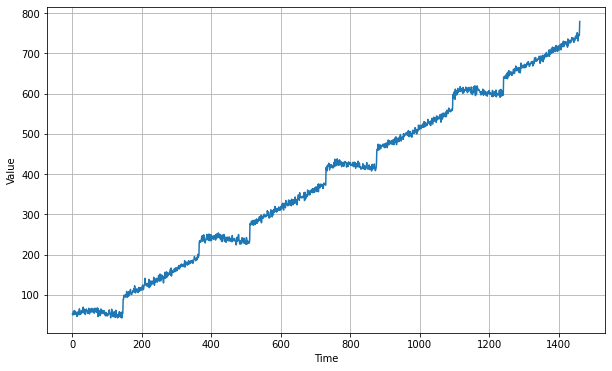

In [ ]:
#PARAMETERS
time=np.arange(4*365+1, dtype="float32")
baseline=10
amplitude=40
slope=0.5
noise_level=5

series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
series += noise(time, noise_level, seed=42)

mk_plot(time,series)

In [ ]:
#SPLIT DATASET

split_time=1000

time_train=time[:split_time]
x_train=series[:split_time]

time_valid=time[split_time:]
x_valid=series[split_time:]

In [ ]:
#WINDOW DATA

window_size=20
batch_size=32
buffer_size=1000

def windowed_data(series, window_size, batch_size,buffer_size):

  data=tf.data.Dataset.from_tensor_slices(series)

  data=data.window(window_size+1, shift=1, drop_remainder=True)

  data=data.flat_map(lambda window: window.batch(window_size+1))

  data=data.map(lambda window: (window[:-1], window[-1]))

  data=data.shuffle(buffer_size)

  data=data.batch(batch_size).prefetch(1)

  return data

In [ ]:
dataset=windowed_data(x_train,window_size,batch_size,buffer_size)

for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


In [ ]:
#MODEL

model_tune=tf.keras.Sequential([
                                tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                                                       input_shape=[window_size]),
                                tf.keras.layers.SimpleRNN(40, return_sequences=True),
                                tf.keras.layers.SimpleRNN(40),
                                tf.keras.layers.Dense(1),
                                tf.keras.layers.Lambda(lambda x: x*100.0)
                              ])

model_tune.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 20, 1)             0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20, 40)            1680      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
 lambda_3 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#TRAIN MODEL

lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

optimizer=tf.keras.optimizers.SGD(momentum=0.9)
loss=tf.keras.losses.Huber()

model_tune.compile(loss=loss,
                   optimizer=optimizer)

history_tune=model_tune.fit(dataset,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 2s 10ms/step - loss: 316.7991 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 315.0800 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 313.0003 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 310.6638 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 308.0453 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 9ms/step - loss: 305.1115 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 301.8246 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 9ms/step - loss: 298.1427 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 0s 9ms/step - loss: 294.0191 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 0s 10ms/step - loss: 289.4014 - lr: 2.8184e-08
Epoch 1

(1e-08, 0.001, 0.0, 200.0)

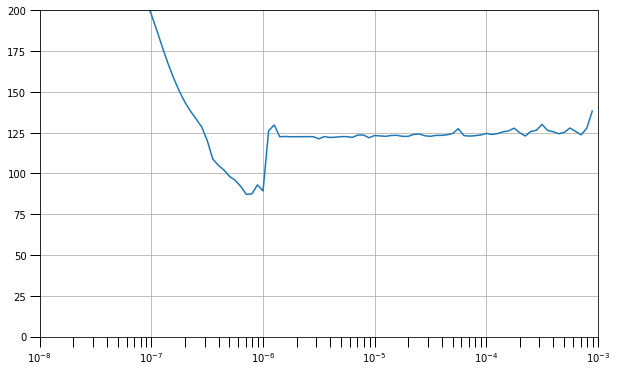

In [ ]:
#LEARNING RATE

lrs=1e-8 * (10**(np.arange(100)/20))

plt.figure(figsize=(10,6))
plt.grid(True)

plt.semilogx(lrs, history_tune.history["loss"])

plt.tick_params('both', length=10, width=1, which='both')

plt.axis([1e-8,1e-3,0,200])

In [ ]:

model_lr=tf.keras.Sequential([
                                tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                                                       input_shape=[window_size]),
                                tf.keras.layers.SimpleRNN(40, return_sequences=True),
                                tf.keras.layers.SimpleRNN(40),
                                tf.keras.layers.Dense(1),
                                tf.keras.layers.Lambda(lambda x: x*100.0)
                              ])

model_lr.compile(loss=loss,
                 optimizer=tf.keras.optimizers.SGD(learning_rate=6e-7, momentum=0.9),
                 metrics=["mae"])

history_tune=model_tune.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 0s 10ms/step - loss: 141.5799
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 142.9660
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 173.1031
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 154.6841
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 155.1929
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 166.5146
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 134.5138
Epoch 8/100
31/31 [==============================] - 0s 10ms/step - loss: 149.0855
Epoch 9/100
31/31 [==============================] - 0s 9ms/step - loss: 162.8149
Epoch 10/100
31/31 [==============================] - 0s 9ms/step - loss: 187.9780
Epoch 11/100
31/31 [==============================] - 0s 9ms/step - loss: 151.3383
Epoch 12/100
31/31 [==============================] - 0s 9ms/step - loss: 151.8536
Epoch 13/1

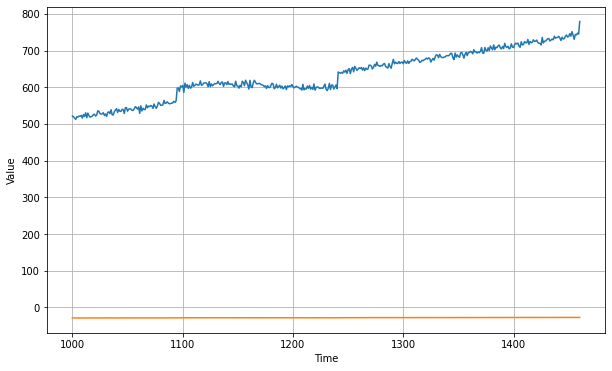

In [ ]:
#MODEL PREDICTION

forecast=[]

forecast_series=series[split_time-window_size:]

for time in range(len(forecast_series)-window_size):
  forecast.append(model_lr.predict(forecast_series[time:time+window_size][np.newaxis]))

results=np.array(forecast).squeeze()

mk_plot(time_valid,(x_valid,results))
                  

In [ ]:
#MODEL FORECAST

def model_forecast(model, series, window_size, batch_size):

  data=tf.data.Dataset.from_tensor_slices(series)
  data=data.window(window_size, shift=1, drop_remainder=True)
  data=data.flat_map(lambda w: w.batch(window_size))
  data=data.map(lambda w: (w[:-1], w[-1]))

  data=data.batch(batch_size).prefetch(1)

  forecast=model.predict(data)

  return forecast

439994.4
660.1383


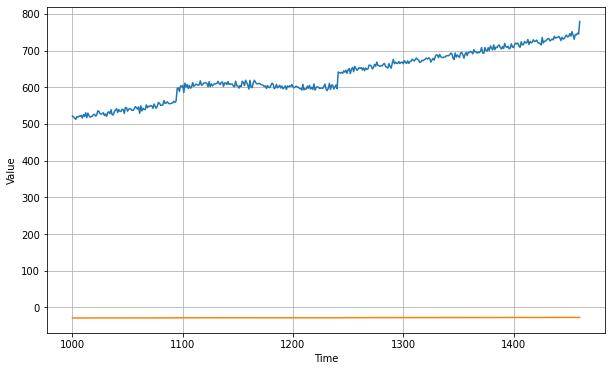

In [ ]:
#RESULTS

forecast_series=series[split_time-window_size:-1]
forecast=model_forecast(model_lr, forecast_series, window_size, batch_size)

results=forecast.squeeze()

print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

mk_plot(time_valid, (x_valid, results))